In [1]:
import numpy as np
import scipy.io
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable
import skimage as skimage
import skimage.filters
from skimage.util import invert
import random

In [183]:
mat = scipy.io.loadmat('Train_Raw.mat')
Train_Raw = mat['Train_Raw']
mat1 = scipy.io.loadmat('Val_Raw.mat')
Val_Raw = mat1['Val_Raw']

In [184]:
def gaussnoise(image,m,v):
    return skimage.util.random_noise(image,mode='gaussian',mean=m,var=v)
def saltpeppernoise(image):
    return skimage.util.random_noise(image,mode='s&p')
def specklenoise(image):
    return skimage.util.random_noise(image,mode='speckle')

In [185]:
l,w = 45,35
Total_Train_Photo = int((Train_Raw.shape[0]*Train_Raw.shape[1])/(l*w))
Total_Val_Photo = int((Val_Raw.shape[0]*Val_Raw.shape[1])/(l*w))
Photo_Train_Col = 37
Photo_Val_Col = 37
print(Total_Val_Photo)

2590


In [186]:
#Normalisasi
Train_Raw_Norm = Train_Raw/255
Val_Raw_Norm = Val_Raw/255

In [187]:
i=0
input_data_raw = np.zeros([Total_Train_Photo,l,w])
val_data_raw = np.zeros([Total_Val_Photo,l,w])
for a in range(0,int(Total_Train_Photo/Photo_Train_Col)):
    for b in range(0,Photo_Train_Col):
        input_data_raw[i,:,:] = Train_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
i,a,b=0,0,0
for a in range(0,int(Total_Val_Photo/Photo_Val_Col)):
    for b in range(0,Photo_Val_Col):
        val_data_raw[i,:,:] = Val_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
        
print(val_data_raw.shape)

(2590, 45, 35)


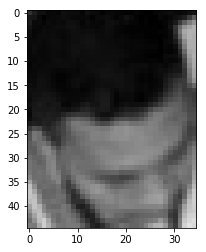

In [188]:
plt.imshow(val_data_raw[23,:,:], cmap='gray', vmin=0, vmax=1)

In [189]:
tar = np.eye(10)
target_train = np.zeros([Total_Train_Photo,10])
target_val = np.zeros([Total_Val_Photo,10])
for d in range(0,10):    
    target_train[0+int(Total_Train_Photo/10)*d:int(Total_Train_Photo/10)+int(Total_Train_Photo/10)*d,:] = tar[d,:]
d=0
for d in range(0,10):
    target_val[0+int(Total_Val_Photo/10)*d:int(Total_Val_Photo/10)+int(Total_Val_Photo/10)*d,:] = tar[d,:]
    
print(target_val.shape)

(2590, 10)


In [190]:
tebal_train, tebal_val = Total_Train_Photo, Total_Val_Photo
target_train3d = np.zeros(shape=(tebal_train, 1, 10))
target_val3d = np.zeros(shape=(tebal_val, 1, 10))
i=0

for i in range(tebal_train):
    target_train3d[i,0,:] = target_train[i,:]
for i in range(tebal_val):
    target_val3d[i,0,:] = target_val[i,:]

In [191]:
def val_in4d(data):
    image_size = [45,35]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

In [192]:
input_val4d = val_in4d(val_data_raw)

print(input_val4d.shape)
print(target_val.shape)

(2590, 1, 45, 35)
(2590, 10)


In [193]:
batch_size_val = int(Total_Val_Photo/10)

In [194]:
input_val4d = torch.from_numpy(input_val4d).float().cuda()
target_val = torch.from_numpy(target_val).float().cuda()

dataset_val = torch.utils.data.TensorDataset(input_val4d, target_val)

kwargs = {}
val_loader = torch.utils.data.DataLoader(dataset_val,
                                         batch_size=batch_size_val, 
                                         shuffle=True,**kwargs)

print('There are {} images in the test set'.format(len(dataset_val)))
print('There are {} batches in the testloader'.format(len(val_loader)))

There are 2590 images in the test set
There are 10 batches in the testloader


In [195]:
val_data_gauss1 = np.zeros(shape=(input_val4d.shape[0],45,35))
val_data_gauss5 = np.zeros(shape=(input_val4d.shape[0],45,35))
val_data_sandp = np.zeros(shape=(input_val4d.shape[0],45,35))
val_data_speckle = np.zeros(shape=(input_val4d.shape[0],45,35))
for i in range(0,val_data_raw.shape[0]):
    val_data_gauss1[i,:,:] = gaussnoise(val_data_raw[i,:,:],0,0.01)
for i in range(0,val_data_raw.shape[0]):
    val_data_gauss5[i,:,:] = gaussnoise(val_data_raw[i,:,:],0,0.05)
for i in range(0,val_data_raw.shape[0]):
    val_data_sandp[i,:,:] = saltpeppernoise(val_data_raw[i,:,:])
for i in range(0,val_data_raw.shape[0]):
    val_data_speckle[i,:,:] = specklenoise(val_data_raw[i,:,:])

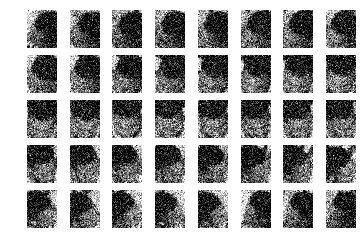

In [196]:
for i in range(0,40):
    plt.subplot(5,8,i+1);plt.imshow(val_data_gauss5[i,:,:], cmap='gray', vmin=0, vmax=1); plt.axis('off')

In [197]:
input_val4d_gauss1 = val_in4d(val_data_gauss1)
input_val4d_gauss5 = val_in4d(val_data_gauss5)
input_val4d_sandp = val_in4d(val_data_sandp)
input_val4d_speckle = val_in4d(val_data_speckle)

print(input_val4d_gauss1.shape)

(2590, 1, 45, 35)


In [198]:
input_val4d_gauss1 = torch.from_numpy(input_val4d_gauss1).float().cuda()
input_val4d_gauss5 = torch.from_numpy(input_val4d_gauss5).float().cuda()
input_val4d_sandp = torch.from_numpy(input_val4d_sandp).float().cuda()
input_val4d_speckle = torch.from_numpy(input_val4d_speckle).float().cuda()

dataset_val_gauss1 = torch.utils.data.TensorDataset(input_val4d_gauss1, target_val)
dataset_val_gauss5 = torch.utils.data.TensorDataset(input_val4d_gauss5, target_val)
dataset_val_sandp = torch.utils.data.TensorDataset(input_val4d_sandp, target_val)
dataset_val_speckle = torch.utils.data.TensorDataset(input_val4d_speckle, target_val)

kwargs = {}
val_loader_gauss1 = torch.utils.data.DataLoader(dataset_val_gauss1, batch_size=batch_size_val, shuffle=True,**kwargs)
val_loader_gauss5 = torch.utils.data.DataLoader(dataset_val_gauss5, batch_size=batch_size_val, shuffle=True,**kwargs)
val_loader_sandp = torch.utils.data.DataLoader(dataset_val_sandp, batch_size=batch_size_val, shuffle=True,**kwargs)
val_loader_speckle = torch.utils.data.DataLoader(dataset_val_speckle, batch_size=batch_size_val, shuffle=True,**kwargs)

In [199]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.fc1 = nn.Linear(45 * 35, 100)
        self.act1 = nn.Tanh()
    
        #elf.fc2 = nn.Linear(500, 100)
        #self.act2 = nn.Tanh()
        
        self.fc3 = nn.Linear(100,10)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        #out = self.layer1(x)
        #out = self.layer2(out)
        out = x.view(-1, 45 * 35)
        out = self.act1(self.fc1(out))
        #out = self.act2(self.fc2(out))
        out = self.act3(self.fc3(out))
        return out

In [200]:
model = ConvNet()
model = model.cuda()    
loss_fn = torch.nn.MSELoss(size_average='false').cuda()        
print(model)
for p in model.parameters():
    print(p.size())

ConvNet(
  (fc1): Linear(in_features=1575, out_features=100, bias=True)
  (act1): Tanh()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (act3): Sigmoid()
)
torch.Size([100, 1575])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [201]:
model.load_state_dict(torch.load('BPNN_3DFaceRecog_Save_5050_Row_1H.pth'))

In [202]:
loss_iter_val = 0.0
benar_val = 0
salah_val = 0
iterations = 0
val_loss = []
val_accuracy = []

model.eval()

for i, (inputs, labels) in enumerate(val_loader):
    inputs = Variable(inputs)
    labels = Variable(labels)
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss_v = loss_fn(outputs, labels)
    loss_iter_val = loss_iter_val+loss_v.item()
    outputs_recog = torch.round(outputs)
    labels_recog = torch.round(labels)
    for hitung in range(batch_size_val):
        if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
            benar_val = benar_val + 1
        else:
            salah_val = salah_val + 1
    iterations = iterations + 1
    
recognition_rate_v = (benar_val/input_val4d.shape[0])*100
val_accuracy.append(recognition_rate_v)
val_loss.append(loss_iter_val)

print('Normal:\nValidation || Validation Loss: {:.7f}, Validation Acc: {:.3f}\n'
              .format(val_loss[-1],
                     val_accuracy[-1]))

loss_iter_val = 0.0
benar_val = 0
salah_val = 0
iterations = 0
val_loss = []
val_accuracy = []

for i, (inputs, labels) in enumerate(val_loader_gauss1):
    inputs = Variable(inputs)
    labels = Variable(labels)
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss_v = loss_fn(outputs, labels)
    loss_iter_val = loss_iter_val+loss_v.item()
    outputs_recog = torch.round(outputs)
    labels_recog = torch.round(labels)
    for hitung in range(batch_size_val):
        if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
            benar_val = benar_val + 1
        else:
            salah_val = salah_val + 1
    iterations = iterations + 1
    
recognition_rate_v = (benar_val/input_val4d.shape[0])*100
val_accuracy.append(recognition_rate_v)
val_loss.append(loss_iter_val)

print('Gaussian 0.01:\nValidation || Validation Loss: {:.7f}, Validation Acc: {:.3f}\n'
              .format(val_loss[-1],
                     val_accuracy[-1]))

loss_iter_val = 0.0
benar_val = 0
salah_val = 0
iterations = 0
val_loss = []
val_accuracy = []

for i, (inputs, labels) in enumerate(val_loader_gauss5):
    inputs = Variable(inputs)
    labels = Variable(labels)
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss_v = loss_fn(outputs, labels)
    loss_iter_val = loss_iter_val+loss_v.item()
    outputs_recog = torch.round(outputs)
    labels_recog = torch.round(labels)
    for hitung in range(batch_size_val):
        if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
            benar_val = benar_val + 1
        else:
            salah_val = salah_val + 1
    iterations = iterations + 1
    
recognition_rate_v = (benar_val/input_val4d.shape[0])*100
val_accuracy.append(recognition_rate_v)
val_loss.append(loss_iter_val)

print('Gaussian 0.05:\nValidation || Validation Loss: {:.7f}, Validation Acc: {:.3f}\n'
              .format(val_loss[-1],
                     val_accuracy[-1]))

loss_iter_val = 0.0
benar_val = 0
salah_val = 0
iterations = 0
val_loss = []
val_accuracy = []

for i, (inputs, labels) in enumerate(val_loader_sandp):
    inputs = Variable(inputs)
    labels = Variable(labels)
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss_v = loss_fn(outputs, labels)
    loss_iter_val = loss_iter_val+loss_v.item()
    outputs_recog = torch.round(outputs)
    labels_recog = torch.round(labels)
    for hitung in range(batch_size_val):
        if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
            benar_val = benar_val + 1
        else:
            salah_val = salah_val + 1
    iterations = iterations + 1
    
recognition_rate_v = (benar_val/input_val4d.shape[0])*100
val_accuracy.append(recognition_rate_v)
val_loss.append(loss_iter_val)

print('Salt & Pepper:\nValidation || Validation Loss: {:.7f}, Validation Acc: {:.3f}\n'
              .format(val_loss[-1],
                     val_accuracy[-1]))

loss_iter_val = 0.0
benar_val = 0
salah_val = 0
iterations = 0
val_loss = []
val_accuracy = []

for i, (inputs, labels) in enumerate(val_loader_speckle):
    inputs = Variable(inputs)
    labels = Variable(labels)
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss_v = loss_fn(outputs, labels)
    loss_iter_val = loss_iter_val+loss_v.item()
    outputs_recog = torch.round(outputs)
    labels_recog = torch.round(labels)
    for hitung in range(batch_size_val):
        if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
            benar_val = benar_val + 1
        else:
            salah_val = salah_val + 1
    iterations = iterations + 1
    
recognition_rate_v = (benar_val/input_val4d.shape[0])*100
val_accuracy.append(recognition_rate_v)
val_loss.append(loss_iter_val)

print('Speckle:\nValidation || Validation Loss: {:.7f}, Validation Acc: {:.3f}\n'
              .format(val_loss[-1],
                     val_accuracy[-1]))

Normal:
Validation || Validation Loss: 0.3688851, Validation Acc: 61.699

Gaussian 0.01:
Validation || Validation Loss: 0.4060252, Validation Acc: 53.668

Gaussian 0.05:
Validation || Validation Loss: 0.5350830, Validation Acc: 37.375

Salt & Pepper:
Validation || Validation Loss: 0.4028930, Validation Acc: 53.398

Speckle:
Validation || Validation Loss: 0.3693069, Validation Acc: 61.583



In [203]:
mat = scipy.io.loadmat('Epochs_and_time_5050R_1H.mat')
Epoch = mat['Epochs']
Train_loss = mat['train_loss']
Time = mat['time']
Train_acc = mat['train_accuracy']

In [204]:
Epoch

array([[14999]])

In [205]:
Train_loss[:,11999]

array([0.36162783])

In [206]:
Train_acc[:,11999]

array([64.15540541])

In [207]:
import time
print('Elapased Time: ', time.strftime("%H:%M:%S", time.gmtime(Time)))

Elapased Time:  03:19:53


NameError: name 'tdqm' is not defined